In [3]:
%pylab inline
import pandas as pd
import highiq
import glob
import act
import datetime

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/rjackson/.conda/envs/pydda_env/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
label_df = pd.read_csv('../notebooks/lidar_labels.csv')

date_list = np.array([datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in label_df["Date"].values])
start_time_list = np.array([datetime.datetime.strptime(x[0:4], '%H%M').time() for x in label_df["Time"].values])
end_time_list = np.array([datetime.datetime.strptime(x[5:], '%H%M').time() for x in label_df["Time"].values])


def get_label(dt):
    label_ind = np.where(np.logical_and.reduce(
        (date_list == dt.date(), start_time_list <= dt.time(), end_time_list > dt.time())))
    if not label_ind[0].size:
        return -1
    my_strings = np.array(
            [x.lower() for x in label_df["Label"].values[label_ind]])
    num_cloud = len(np.where(my_strings == "cloudy")[0]) + \
            len(np.where(my_strings == "cloud")[0])
    num_clear = len(np.where(my_strings == "clear")[0])
    num_rain = len(np.where(my_strings == "rain")[0])
    my_string = label_df["Label"].values[label_ind][0]

    pct_cloud = num_cloud/len(my_strings)

    if num_rain > 0:
        return 2
    elif pct_cloud < 0.25:
        return 0
    elif pct_cloud >= 0.25 and pct_cloud <= 0.75:
        return 1
    else:
        return 1

    raise ValueError("Invalid value %s for label" % my_string)


def nn_classifier(input_array, num_layers=2, num_channel_start=2):
    inp = Input(shape=(input_array.shape[1],), name='input')
    layer = inp
    num_channels = num_channel_start
    for i in range(num_layers):
        
        layer = Dense(num_channels)(layer)
        #layer = Dropout(0.25)(layer)
        layer = BatchNormalization()(layer)
        layer = Activation('relu')(layer)
        #layer = Dropout(0.25)(layer)
        #layer = Dropout(0.75)(layer)
        #num_channels = num_channels * 2
        
    output = Dense(3, activation='softmax',
            name='output')(layer)

    return Model(inp, output)


def dt64_to_dt(dt):
    ts = (dt - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    return datetime.datetime.utcfromtimestamp(ts)

In [ ]:
label_df[label_df.Date == "2017-08-03"]

In [88]:
glob.glob('/lambda_stor/data/rjackson/sgp_lidar/*20170803*')

['/lambda_stor/data/rjackson/sgp_lidar/sgpdlacfC1.a1.20170803.110112.moments.nc',
 '/lambda_stor/data/rjackson/sgp_lidar/sgpdlacfC1.a1.20170803.120113.moments.nc',
 '/lambda_stor/data/rjackson/sgp_lidar/sgpdlacfC1.a1.20170803.070112.moments.nc',
 '/lambda_stor/data/rjackson/sgp_lidar/sgpdlacfC1.a1.20170803.160112.moments.nc',
 '/lambda_stor/data/rjackson/sgp_lidar/sgpdlacfC1.a1.20170803.080113.moments.nc',
 '/lambda_stor/data/rjackson/sgp_lidar/sgpdlacfC1.a1.20170803.090113.moments.nc',
 '/lambda_stor/data/rjackson/sgp_lidar/sgpdlacfC1.a1.20170803.190112.moments.nc',
 '/lambda_stor/data/rjackson/sgp_lidar/sgpdlacfC1.a1.20170803.220112.moments.nc',
 '/lambda_stor/data/rjackson/sgp_lidar/sgpdlacfC1.a1.20170803.150112.moments.nc',
 '/lambda_stor/data/rjackson/sgp_lidar/sgpdlacfC1.a1.20170803.170113.moments.nc',
 '/lambda_stor/data/rjackson/sgp_lidar/sgpdlacfC1.a1.20170803.180113.moments.nc',
 '/lambda_stor/data/rjackson/sgp_lidar/sgpdlacfC1.a1.20170803.200113.moments.nc',
 '/lambda_stor/d

In [5]:
cloudy_time = act.io.armfiles.read_netcdf('/lcrc/group/earthscience/rjackson/sgp_lidar/processed_moments/sgpdlacfC1.a1.20170801.010112.moments.nc')

/home/rjackson/.conda/envs/pydda_env/lib/python3.9/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


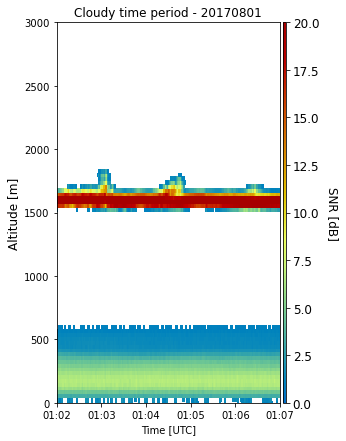

In [6]:
display = act.plotting.TimeSeriesDisplay(cloudy_time, figsize=(4, 7))
cloudy_time['snr'] = cloudy_time['snr'].where(cloudy_time.snr > 1)
display.plot('snr', cmap='act_HomeyerRainbow', vmin=0, vmax=20)
display.set_xrng([pd.Timestamp('2017-08-01T01:02:00'), pd.Timestamp('2017-08-01T01:07:00')])
display.axes[0].set_ylabel('Altitude [m]', fontsize=12)
display.cbs[0].set_label('SNR [dB]\n', fontsize=12, labelpad=20)
display.cbs[0].ax.tick_params(labelsize=12)
display.axes[0].set_ylim([0, 3000])
display.axes[0].set_title('Cloudy time period - 20170801')
display.fig.savefig('Cloudy_time.png', dpi=300, bbox_inches="tight")

In [7]:
rainy_time = act.io.armfiles.read_netcdf('/lcrc/group/earthscience/rjackson/sgp_lidar/processed_moments/sgpdlacfC1.a1.20170803.210113.moments.nc')

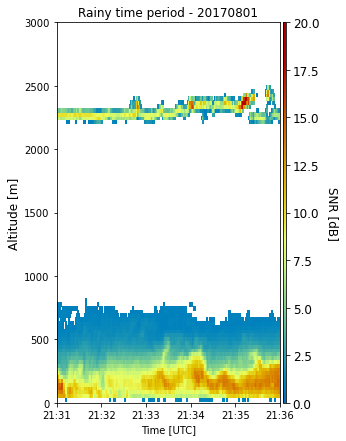

In [8]:
display = act.plotting.TimeSeriesDisplay(rainy_time, figsize=(4, 7))
rainy_time['snr'] = rainy_time['snr'].where(rainy_time.snr > 1)
display.plot('snr', cmap='act_HomeyerRainbow', vmin=0, vmax=20)
display.set_xrng([pd.Timestamp('2017-08-03T21:31:00'), pd.Timestamp('2017-08-03T21:36:00')])
display.axes[0].set_ylabel('Altitude [m]', fontsize=12)
display.cbs[0].set_label('SNR [dB]\n', fontsize=12, labelpad=20)
display.cbs[0].ax.tick_params(labelsize=12)
display.axes[0].set_title('Rainy time period - 20170801')
display.axes[0].set_ylim([0, 3000])
display.fig.savefig('Rainy_time.png', dpi=300, bbox_inches="tight")

In [9]:
clear_time = act.io.armfiles.read_netcdf('/lcrc/group/earthscience/rjackson/sgp_lidar/processed_moments/sgpdlacfC1.a1.20170803.070112.moments.nc')

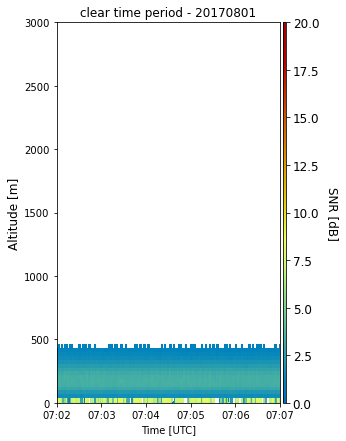

In [10]:
display = act.plotting.TimeSeriesDisplay(clear_time, figsize=(4, 7))
clear_time['snr'] = clear_time['snr'].where(clear_time.snr > 1)
display.plot('snr', cmap='act_HomeyerRainbow', vmin=0, vmax=20)
display.set_xrng([pd.Timestamp('2017-08-03T07:02:00'), pd.Timestamp('2017-08-03T07:07:00')])
display.axes[0].set_ylabel('Altitude [m]', fontsize=12)
display.cbs[0].set_label('SNR [dB]\n', fontsize=12, labelpad=20)
display.cbs[0].ax.tick_params(labelsize=12)
display.axes[0].set_title('clear time period - 20170801')
display.axes[0].set_ylim([0, 3000])
display.fig.savefig('clear_time.png', dpi=300, bbox_inches="tight")